In [1]:
import numpy as np
import pandas as pd
import joblib as jb
from tqdm.contrib.concurrent import process_map
from datetime import datetime
import os
import glob
import minas as mg
import math
import shutil
import datetime
datetime_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")


### Initial Configuration

In [2]:
# Selecione o tipo de técnica/modelo a ser utilizado
# Exemplos: 'RF' para Random Forest, 'XGB' para XGBoost
model_type = 'RF'
# model_type = 'RF'

# Selecione o survey e base de treinamento
# Exemplos: 'JPLUSL', 'JPLUSA', 'SPLUSL', 'SPLUSA'
survey_train= 'JPLUSL' 

# Selecione o grau de restrição do modelo
# Exemplos: '_01' para mais restrito, '_02' para menos restrito
model_rest = '_01'  
# model_rest = '_02' 

# Exemplos: 'JPLUS' ou 'JPAS'
survey_filter = 'JPLUS'  # altere para 'JPAS' conforme necessário

# Carregar dados onde serão aplicados os modelos
input_df_path = 'data/input_jplusgK_01.csv'

# Particionamento, filtragem e criação da coluna good_magnitudes em chunks grandes
part_size = 20000
mag_error_hard_cut = 5.0

# Carregar os modelos
training_id = '20251007150057'  
model_dir = f'../training/models'  # diretório onde estão os modelos
prefix = 'imp_'  # 'imp_' = mais importantes 'all_' = todas as features


# Configuração do Monte Carlo: repetiçoes, quantas repetiçoes aplicar por vez e numero de nucleos
mc_reps = 100                
batch_partitions = 100      # (maior = mais memoria gasta)
n_workers = 10              

### Prepare Dataframe


In [3]:
# Definir limites
good_mag_cut = 0.1 if model_rest == '_01' else 0.2

# Inicializar parâmetros do loop
temp_dir = f'temp_data{model_rest}'
os.makedirs(temp_dir, exist_ok=True)
part_iteration = 0
len_current_df = part_size

while len_current_df == part_size:
    # Ler parte do DataFrame
    stars_raw = pd.read_csv(input_df_path,
                            skiprows=range(1, 1 + (part_iteration * part_size)),
                            nrows=part_size)
    len_current_df = len(stars_raw)

    # Filtrar por erro máximo
    magnitudes = mg.FILTERS[survey_filter]
    for filter_name in magnitudes:
        error_name = f"{filter_name}_err"
        stars_raw = stars_raw[stars_raw[error_name] <= mag_error_hard_cut]

    stars_raw = stars_raw.reset_index(drop=True)
    # Remover set_index('TILE_ID', ...) para manter TILE_ID como coluna

    # Criar flags de magnitudes boas
    good_mags_df = pd.DataFrame(index=stars_raw.index)
    for filter_name in magnitudes:
        error_name = f"{filter_name}_err"
        good_flag = stars_raw[error_name].apply(lambda x: x <= good_mag_cut)
        good_mags_df[error_name] = good_flag

    stars_raw['good_magnitudes'] = good_mags_df.sum(axis=1)

    # Salvar chunk processado garantindo que TILE_ID seja coluna, apenas se não estiver vazio
    if len(stars_raw) > 0:
        stars_raw.to_csv(f'{temp_dir}/vac_input_{(part_iteration + 1):03d}.csv', index=False)
    part_iteration += 1

### Import Models

In [4]:
def load_xgb_model(path):
    model = XGBRegressor()
    model.load_model(path)
    return model

def load_rf_model(path):
    return jb.load(open(path, 'rb'))

if model_type == 'XGB':
    teff_pipeline = load_xgb_model(f'{model_dir}/{prefix}{training_id}_{survey_train}_teff{model_rest}_{model_type}.json')
    logg_pipeline = load_xgb_model(f'{model_dir}/{prefix}{training_id}_{survey_train}_logg{model_rest}_{model_type}.json')
    feh_pipeline = load_xgb_model(f'{model_dir}/{prefix}{training_id}_{survey_train}_feh{model_rest}_{model_type}.json')
elif model_type == 'RF':
    teff_pipeline = load_rf_model(f'{model_dir}/{prefix}{training_id}_{survey_train}_teff{model_rest}_{model_type}.sav')
    logg_pipeline = load_rf_model(f'{model_dir}/{prefix}{training_id}_{survey_train}_logg{model_rest}_{model_type}.sav')
    feh_pipeline = load_rf_model(f'{model_dir}/{prefix}{training_id}_{survey_train}_feh{model_rest}_{model_type}.sav')
else:
    raise ValueError('Tipo de modelo não suportado: use "XGB" ou "RF"')

models = {
    'teff': teff_pipeline,
    'logg': logg_pipeline,
    'feh': feh_pipeline
}

### Iniciar o Predictor

In [5]:
# Definir variáveis
id_col = 'TILE_ID'
ra_col = 'RA'
dec_col = 'DEC'
dist_col = 'Dist'
keep_cols = ['good_magnitudes']

models_dir = 'pred_results'
os.makedirs(models_dir, exist_ok=True)

# Inicializar um DataFrame para as previsões
skel_df = pd.DataFrame(columns=['TILE_ID', 'RA', 'DEC'] + \
                        [f'{x}{y}' for x in models.keys() for y in ['', '_err']] + \
                        keep_cols)

# Selecionar filtros dinamicamente
mag_cols = mg.FILTERS[survey_filter]
err_cols = [f'{x}_err' for x in mag_cols]

from minas.models import Predictor
predictor = Predictor(
    id_col=id_col,
    mag_cols=mag_cols,
    err_cols=err_cols,
    dist_col=dist_col,
    correction_pairs=None,
    models=models,
    mc_reps=mc_reps,
    batch_partitions=batch_partitions
)

# Caminho para salvar o output
output_path = f'{models_dir}/{datetime_str}_{survey_train}{model_rest}_{model_type}.csv'
skel_df.to_csv(output_path, index = False, mode = 'w')

In [ ]:
# Processar cada chunk e salvar incrementalmente
chunk_paths = sorted(glob.glob(f'{temp_dir}/vac_input_*.csv'))
for i, chunk_path in enumerate(chunk_paths):
    print(f'Processando chunk {i+1}/{len(chunk_paths)}: {chunk_path}')
    chunk_data = pd.read_csv(chunk_path)
    
    # Garantir que RA, DEC e good_magnitudes estejam presentes no chunk
    for col in [ra_col, dec_col, 'good_magnitudes']:
        if col not in chunk_data.columns:
            raise ValueError(f'Coluna {col} não encontrada no chunk!')
    combinations = [(chunk_data, output_path, keep_cols, 'a', False)]
    print(f'Aplicando modelo no chunk {i+1}...')
    
    if model_type == 'RF':
        r = process_map(predictor.predict_parameters, combinations, max_workers=n_workers, total=len(combinations))
    elif model_type == 'XGB':
        for combination in combinations:
            predictor.predict_parameters(combination)
    
    print(f'Chunk {i+1} processado e salvo em {output_path}.')

# Excluir pasta temporária ao final
print('Removendo pasta temporária...')
shutil.rmtree(temp_dir)
print('Processamento finalizado.')

Processando chunk 1/4: temp_data_01/vac_input_001.csv
Aplicando modelo no chunk 1...


  0%|          | 0/1 [00:00<?, ?it/s]

Chunk 1 processado e salvo em pred_results/20251007183342_JPLUSL_01_RF.csv.
Processando chunk 2/4: temp_data_01/vac_input_002.csv
Aplicando modelo no chunk 2...


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Defina os parâmetros e o DataFrame de resultados
parametros = ['teff', 'logg', 'feh']
result_df = pd.read_csv(output_path)  # ou use o DataFrame correto se já estiver carregado

print('=' * 60)
print(f'RESUMO ESTATÍSTICO DOS ERROS DAS PREDIÇÕES | Modelos Aplicados: {survey_train}{model_rest}_{model_type}')
print(f"  • Total de objetos: {len(result_df)}")
print('=' * 60)

for param in parametros:
    err_col = f"{param}_err"
    if err_col in result_df.columns:
        vals = result_df[err_col].dropna()
        param_name = {
            'teff': 'Temperatura Efetiva (K)',
            'logg': 'Gravidade Superficial (dex)',
            'feh': 'Metalicidade [Fe/H] (dex)'
        }[param]
        print(f"\n{param_name} ({param.upper()}):")
        print(f"  • Média:           {vals.mean():.2f}")
        print(f"  • Desvio Padrão:   {vals.std():.2f}")
        print(f"  • Mediana:         {vals.median():.2f}")


RESUMO ESTATÍSTICO DOS ERROS DAS PREDIÇÕES | Modelos Aplicados: JPLUSL_01_RF
  • Total de objetos: 60731

Temperatura Efetiva (K) (TEFF):
  • Média:           23.96
  • Desvio Padrão:   25.36
  • Mediana:         16.12

Gravidade Superficial (dex) (LOGG):
  • Média:           0.02
  • Desvio Padrão:   0.02
  • Mediana:         0.01

Metalicidade [Fe/H] (dex) (FEH):
  • Média:           0.06
  • Desvio Padrão:   0.07
  • Mediana:         0.03


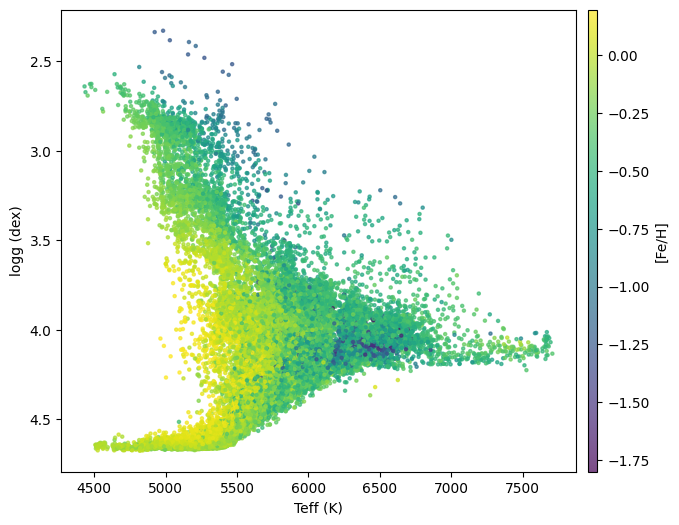

In [42]:
# Diagrama de Kiel: Teff vs logg com colormap de [Fe/H]
import matplotlib.pyplot as plt
import pandas as pd

# Caminho do arquivo de previsão
csv_path = 'pred_results/20251007183342_JPLUSL_01_RF.csv'
result_df = pd.read_csv(csv_path)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    result_df['teff'],
    result_df['logg'],
    c=result_df['feh'],
    cmap='viridis',
    s=5,
    alpha=0.7
)

cbar = plt.colorbar(sc, aspect=50, pad=0.02)
cbar.set_label('[Fe/H]')
plt.xlabel('Teff (K)')
plt.ylabel('logg (dex)')
plt.gca().invert_yaxis()
plt.show()